In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyddm
import os
import seaborn as sns
import matplotlib.cm as cm

In [2]:
# Read in the measures_vel.csv file
df = pd.read_csv("processed/measures/measures_vel.csv", sep=';')

# Filter out invalid rows based on response time, decision, and a_mean
T_dur = 4.0
T_min = 0.5
df = df[(df.Response_Time < T_dur) & (df.Response_Time > T_min)]
df = df[~df['Decision'].isin(['not finish overtake', 'calculation error', 'simulation error'])]
df = df[df['a_mean'].notnull()]


# cluster the v_start values
terciles = df["v_start"].quantile([0.33, 0.66])


def assign_tercile_label(x):
   if x <= terciles[0.33]:
       return "T1"
   elif x <= terciles[0.66]:
       return "T2"
   else:
       return "T3"


df["v_start_cluster"] = df["v_start"].apply(assign_tercile_label)
tercile_means = df.groupby("v_start_cluster")["v_start"].mean()
df["v_start_cluster"].replace({"T1": round(tercile_means[0],2), "T2": round(tercile_means[1],2), "T3": round(tercile_means[2],2)},
                                       inplace=True)
df['Decision'] = df['Decision'].apply(lambda x: 1 if x == 'Accepted gap' else 0)
# read in the actual data
# read in the simulated data


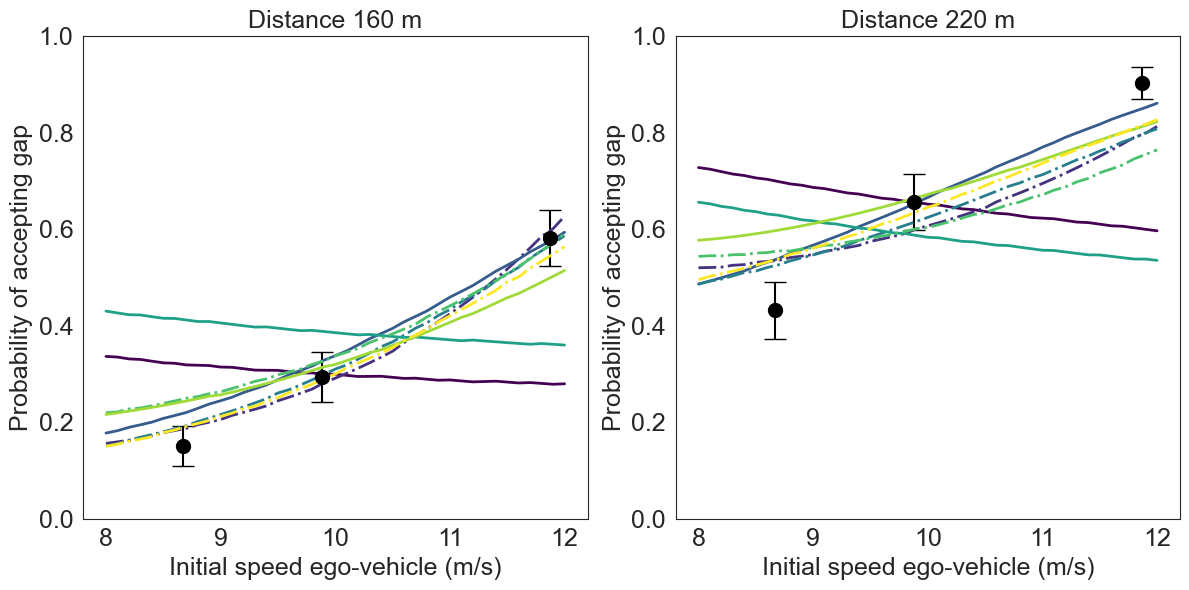

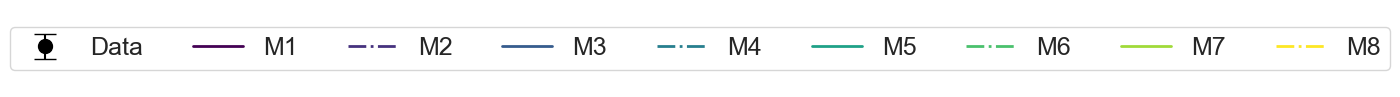

In [3]:
# Prompt the user to enter the results type
results_type = input("Enter the results type ('paper' or 'own'): ")

# Define the base directory path
if results_type.lower() == 'paper':
    base_directory = "modeling/Results_paper"
else:
    base_directory = "modeling"
subfolder_name = "Figures"
# Read the simulated data from CSV files
simulated_files = [
   ("ModelOutOfTheBox", f"{base_directory}/subj_sim_measures_ModelOutOfTheBox.csv"),
   ("ModelOutOfTheBox_Bias", f"{base_directory}/subj_sim_measures_ModelOutOfTheBox_Bias.csv"),
   ("ModelTTADistVel", f"{base_directory}/subj_sim_measures_ModelTTADistVel.csv"),
   ("ModelTTADistVel_Bias", f"{base_directory}/subj_sim_measures_ModelTTADistVel_Bias.csv"),
   ("Model_Drift_in_Bound", f"{base_directory}/subj_sim_measures_Model_Drift_in_Bound.csv"),
   ("Model_Drift_in_Bound_Bias", f"{base_directory}/subj_sim_measures_Model_Drift_in_Bound_Bias.csv"),
   ("Model_Vel_Drift_in_Bound", f"{base_directory}/subj_sim_measures_Model_Vel_Drift_in_Bound.csv"),
   ("Model_Vel_Drift_in_Bound_Bias", f"{base_directory}/subj_sim_measures_Model_Vel_Drift_in_Bound_Bias.csv")
]


# calculate the mean of the actual data for each condition and v_start_cluster
actual_means = df.groupby(['Condition_Dist', 'v_start_cluster'])['Decision'].mean().reset_index()


# calculate the standard error of the mean for each condition and v_start_cluster
actual_sems = df.groupby(['Condition_Dist', 'v_start_cluster'])['Decision'].sem().reset_index()


# merge the actual and simulated datasets on their common columns
merged_df = actual_means


# merge the actual sems with the merged dataset
merged_df = pd.merge(merged_df, actual_sems, how='left',
                     left_on=['Condition_Dist', 'v_start_cluster'],
                     right_on=['Condition_Dist', 'v_start_cluster'])

plt.rcParams['figure.facecolor'] = 'white'
sns.set_style('white')
font_size = 18
legend_font_size = 18
marker_size = 10


# create subplots for each condition distance
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


legend_handles = []  # List to store legend handles for the separate legend plot


for i, condition_dist in enumerate([160, 220]):
    # filter merged dataset for the specific condition distance
    merged = merged_df[merged_df['Condition_Dist'] == condition_dist]


    # create a subplot for the current condition distance
    ax = axs[i]


    # plot the actual data
    data_handle=ax.errorbar(x=merged['v_start_cluster'], y=merged['Decision_x'], yerr=2 * merged['Decision_y'],
                fmt='o', capsize=8, color='black', markersize=marker_size, label='Data')
    if i == 0:
        legend_handles.append(data_handle)
    # get the number of simulated files
    num_simulated = len(simulated_files)


    # iterate over simulated files and plot the simulated data
    for j, (model_name, filename) in enumerate(simulated_files):
        simulated_df = pd.read_csv(filename)
        condition_simulated = simulated_df[simulated_df['Condition_Dist'] == condition_dist]
        label = f'M{j + 1}'


        # determine the color based on the index
        color = cm.viridis(j / (num_simulated - 1))


        # Alternate between solid and dash-dotted lines
        linestyle = '-' if j % 2 == 0 else '-.'


        ax.plot(condition_simulated['v_start_cluster'], condition_simulated['Decision'],
                linestyle=linestyle, linewidth=2, color=color, label=label)


        if i == 0:
            # Store handles for the separate legend plot
            legend_handles.append(ax.plot([], [], linestyle=linestyle, linewidth=2, color=color, label=label)[0])


    ax.set_xlabel('Initial speed ego-vehicle (m/s)', fontsize=font_size)
    ax.set_ylabel('Probability of accepting gap', fontsize=font_size)
    ax.set_title(f'Distance {condition_dist} m', fontsize=font_size)
    #ax.legend(fontsize=legend_font_size)
    ax.set_ylim([0, 1])
    ax.grid(False)


    # Increase font size in current subplot
    ax.tick_params(labelsize=font_size)

# Save the figure with plots
plt.tight_layout()
# Set the filename and path for saving the figure
figure_filename = "Simulated_Probability.png"
figure_path = os.path.join(base_directory, subfolder_name, figure_filename)
plt.savefig(figure_path, format='png')


# Create a separate plot for the legend
fig_legend = plt.figure(figsize=(14.3, 1))
ax_legend = fig_legend.add_subplot(111)


# Create a horizontal legend
ax_legend.legend(handles=legend_handles, loc='center', ncol=len(legend_handles), fontsize=legend_font_size)
ax_legend.axis('off')

# Save the legend as a separate PNG file
fig_legend.savefig('Legend.png', format='png')
legend_filename = "Legend.png"
legend_path = os.path.join(base_directory, subfolder_name, legend_filename)
plt.savefig(legend_path, format='png')
# Show the plots
plt.show()


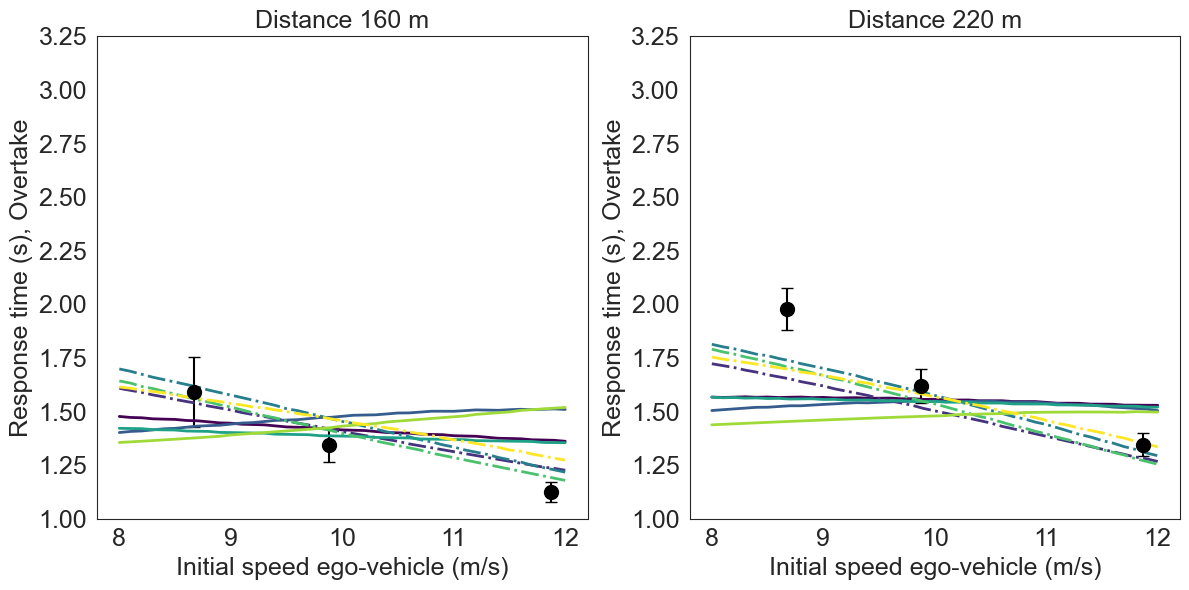

In [4]:
# calculate the mean of the actual data for each condition and v_start_cluster
actual_means = df[df['Decision'] == 1].groupby(['Condition_Dist', 'v_start_cluster'])['Response_Time'].mean().reset_index()


# calculate the standard error of the mean for each condition and v_start_cluster
actual_sems = df[df['Decision'] == 1].groupby(['Condition_Dist', 'v_start_cluster'])['Response_Time'].sem().reset_index()


# merge the actual and simulated datasets on their common columns
merged_df = actual_means


# merge the actual sems with the merged dataset
merged_df = pd.merge(merged_df, actual_sems, how='left',
                    left_on=['Condition_Dist', 'v_start_cluster'],
                    right_on=['Condition_Dist', 'v_start_cluster'])


colors = ['1', '2', '3', '4', '5', '6', '7', '8']

# create subplots for each condition distance
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


for i, condition_dist in enumerate([160, 220]):
   # filter merged dataset for the specific condition distance
   merged = merged_df[merged_df['Condition_Dist'] == condition_dist]


   # create a subplot for the current condition distance
   ax = axs[i]


   # plot the actual data
   ax.errorbar(x=merged['v_start_cluster'], y=merged['Response_Time_x'], yerr=2*merged['Response_Time_y'],
               fmt='o', capsize=4, color='black',markersize=marker_size, label='Data')


   # iterate over simulated files and plot the simulated data
      # iterate over simulated files and plot the simulated data
# get the number of simulated files
   num_simulated = len(simulated_files)
   for j, (color, (model_name, filename)) in enumerate(zip(colors, simulated_files)):
        simulated_df = pd.read_csv(filename)
        condition_simulated = simulated_df[simulated_df['Condition_Dist'] == condition_dist]
        label = f'M{j+1}'
                # determine the color based on the index
        color = cm.viridis(j / (num_simulated - 1))


        # Alternate between solid and dash-dotted lines
        linestyle = '-' if j % 2 == 0 else '-.'
        ax.plot(condition_simulated['v_start_cluster'], condition_simulated['RT_go'],
                  linestyle=linestyle, linewidth=2, color=color, label=label)


   ax.set_xlabel('Initial speed ego-vehicle (m/s)', fontsize=font_size)
   ax.set_ylabel('Response time (s), Overtake', fontsize=font_size)
   ax.set_title(f'Distance {condition_dist} m', fontsize=font_size)
  #ax.legend()
   # Fix the y-axis range
   ax.set_ylim([1, 3.25])
   ax.grid(False)


# Increase font size in current subplot
   ax.tick_params(labelsize=font_size)
plt.tight_layout()
figure_filename = "Simulated_RT_accepted.png"
figure_path = os.path.join(base_directory, subfolder_name, figure_filename)
plt.savefig(figure_path, format='png')
plt.show()



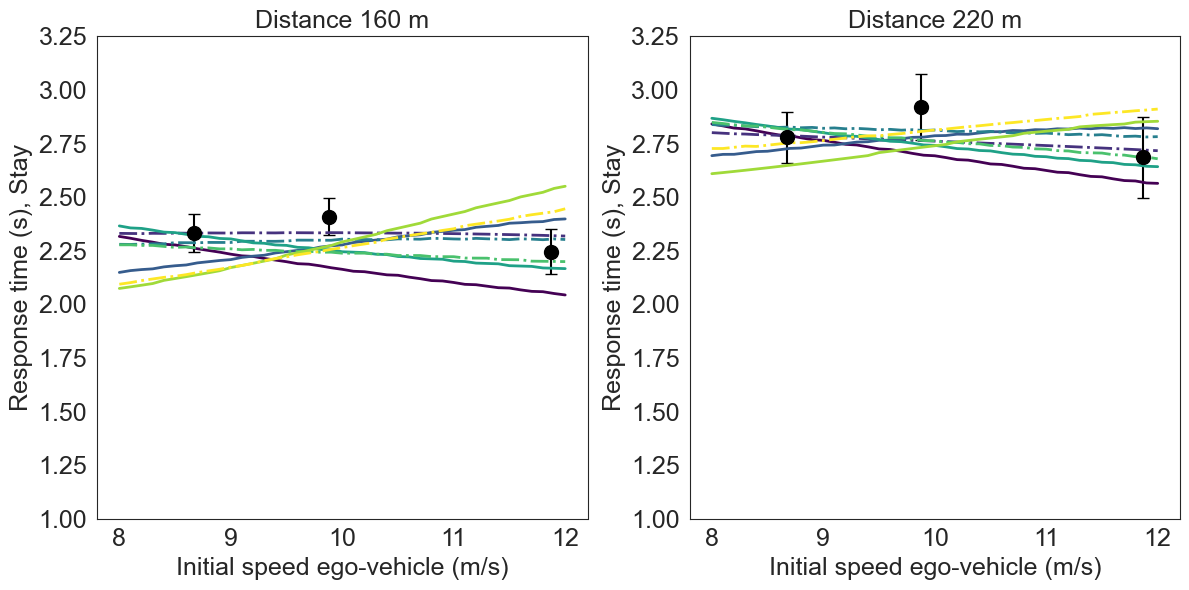

In [5]:
# calculate the mean of the actual data for each condition and v_start_cluster
actual_means = df[df['Decision'] == 0].groupby(['Condition_Dist', 'v_start_cluster'])['Response_Time'].mean().reset_index()


# calculate the standard error of the mean for each condition and v_start_cluster
actual_sems = df[df['Decision'] == 0].groupby(['Condition_Dist', 'v_start_cluster'])['Response_Time'].sem().reset_index()


# merge the actual and simulated datasets on their common columns
merged_df = actual_means


# merge the actual sems with the merged dataset
merged_df = pd.merge(merged_df, actual_sems, how='left',
                    left_on=['Condition_Dist', 'v_start_cluster'],
                    right_on=['Condition_Dist', 'v_start_cluster'])
# create subplots for each condition distance
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


for i, condition_dist in enumerate([160, 220]):
   # filter merged dataset for the specific condition distance
   merged = merged_df[merged_df['Condition_Dist'] == condition_dist]


   # create a subplot for the current condition distance
   ax = axs[i]


   # plot the actual data
   ax.errorbar(x=merged['v_start_cluster'], y=merged['Response_Time_x'], yerr=2*merged['Response_Time_y'],
               fmt='o', capsize=4, color='black',markersize=marker_size, label='Data')


   # iterate over simulated files and plot the simulated data
      # iterate over simulated files and plot the simulated data
# get the number of simulated files
   num_simulated = len(simulated_files)
   for j, (color, (model_name, filename)) in enumerate(zip(colors, simulated_files)):
        simulated_df = pd.read_csv(filename)
        condition_simulated = simulated_df[simulated_df['Condition_Dist'] == condition_dist]
        label = f'M{j+1}'
                # determine the color based on the index
        color = cm.viridis(j / (num_simulated - 1))


        # Alternate between solid and dash-dotted lines
        linestyle = '-' if j % 2 == 0 else '-.'
        ax.plot(condition_simulated['v_start_cluster'], condition_simulated['RT_stay'],
                  linestyle=linestyle, linewidth=2, color=color, label=label)


   ax.set_xlabel('Initial speed ego-vehicle (m/s)', fontsize=font_size)
   ax.set_ylabel('Response time (s), Stay', fontsize=font_size)
   ax.set_title(f'Distance {condition_dist} m', fontsize=font_size)
  #ax.legend()
   # Fix the y-axis range
   ax.set_ylim([1, 3.25])
   ax.grid(False)


# Increase font size in current subplot
   ax.tick_params(labelsize=font_size)
plt.tight_layout()
figure_filename = "Simulated_RT_rejected.png"
figure_path = os.path.join(base_directory, subfolder_name, figure_filename)
plt.savefig(figure_path, format='png')
plt.show()
